In [ ]:
# !pip install rasterio opencv-python numpy pandas matplotlib
# ! pip install tqdm

In [1]:
import rasterio
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = satellite_to_gray(sat_img)


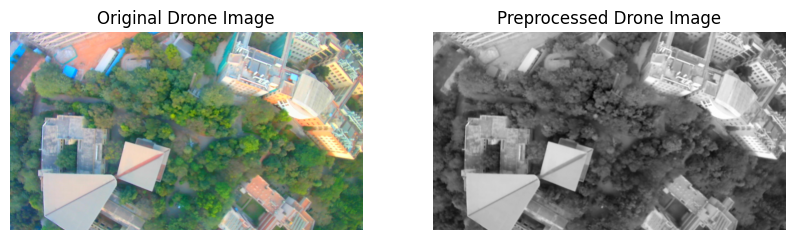

In [3]:
name = list(drone_imgs.keys())[200]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(drone_imgs[name], cv2.COLOR_BGR2RGB))
plt.title("Original Drone Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(drone_imgs_proc[name], cmap='gray')
plt.title("Preprocessed Drone Image")
plt.axis("off")

plt.show()

In [4]:
drone_imgs[name].shape

(720, 1280, 3)

In [51]:
sat_gray = normalize_uint8(satellite_to_gray(sat_img))

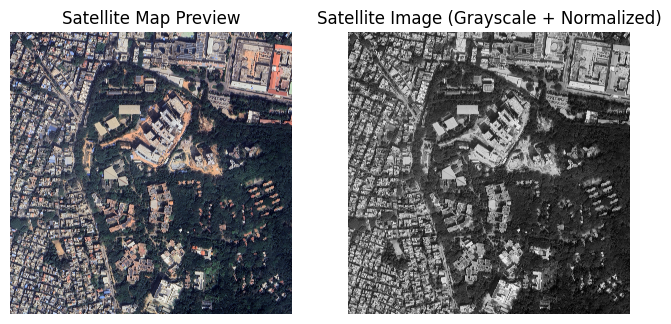

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(121).imshow(sat_img[:, :, :3])  # use first 3 bands
plt.title("Satellite Map Preview")
plt.axis("off")
plt.subplot(122).imshow(sat_gray, cmap="gray")
plt.title("Satellite Image (Grayscale + Normalized)")
plt.axis("off")
plt.show()

# Cross-View Feature Matching:

● This is the core of the challenge. You need to find the specific location on the large
satellite map that corresponds to the drone image.

● You should implement a feature-based matching pipeline:

○ Choose a feature detector/descriptor: SIFT, SURF, or ORB are common
choices. You must justify your choice.

○ Matching Strategy: Develop a strategy to efficiently find the best match for the
drone image's features within the vast number of features from the satellite map.

A brute-force search is computationally expensive; consider sliding-window
approaches or other optimisations.

○ Filter Matches: Use techniques like Lowe's ratio test and RANSAC with a
geometric transformation (e.g., Homography or Affine) to find a set of reliable,
geometrically consistent matches.

# Compare feature extracted using different methods

In [9]:
# !git clone https://github.com/magicleap/SuperGluePretrainedNetwork
# !ls SuperGluePretrainedNetwork/
# from SuperGluePretrainedNetwork.models.superpoint import SuperPoint


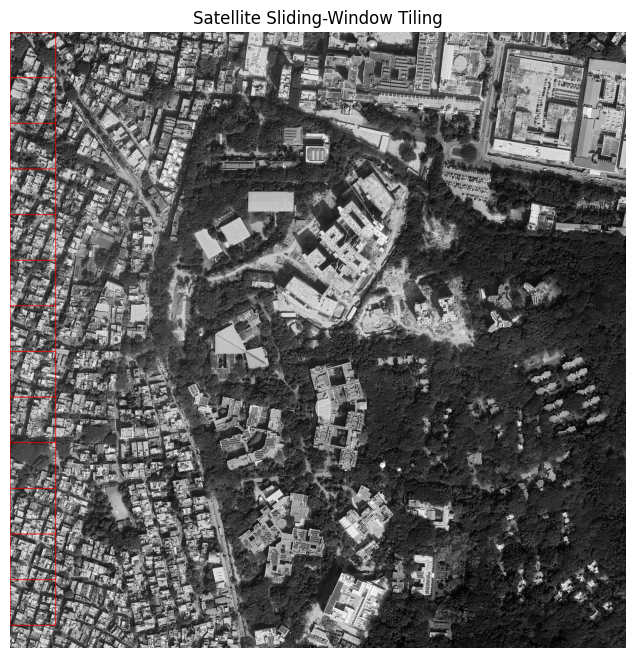

In [10]:
sat_tiles = tile_image(sat_gray)
vis = cv2.cvtColor(sat_gray, cv2.COLOR_GRAY2RGB)

for t in sat_tiles[::50]:
    x, y = t["offset"]
    cv2.rectangle(vis, (x,y), (x+512,y+512), (255,0,0), 8)

plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.title("Satellite Sliding-Window Tiling")
plt.axis("off")
plt.show()

In [ ]:
sat_features = []

for t in sat_tiles:
    kp, des = extract_sift(t["tile"])
    if des is not None:
        sat_features.append({
            "kp": kp,
            "des": des,
            "offset": t["offset"],
            "tile": t["tile"]
        })
sample_tile = sat_features[0]["tile"]
# kp, des = extract_sift(sample_tile)
# kp_d, des_d = extract_sift(drone_imgs_proc[name])
sample_tile = sat_features[0]["tile"]
# kp, des = extract_sift(sample_tile)
# kp_d, des_d = extract_sift(drone_imgs_proc[name])

In [102]:
# # functions
# def tile_image(img, tile_size=512, stride=256):
#     tiles = []
#     h, w = img.shape
#     for y in range(0, h - tile_size, stride):
#         for x in range(0, w - tile_size, stride):
#             tiles.append({
#                 "tile": img[y:y+tile_size, x:x+tile_size],
#                 "offset": (x, y)
#             })
#     return tiles

# def extract_orb(img):
#     return orb.detectAndCompute(img, None)

# def match_features(des_d, des_s, ratio=0.75):
#     matches = bf.knnMatch(des_d, des_s, k=2)
#     return [m for m,n in matches if m.distance < ratio * n.distance]
# # def match_sift(des_d, des_s, ratio=0.75):
# #     matches = flann.knnMatch(des_d, des_s, k=2)
# #     return [m for m,n in matches if m.distance < ratio * n.distance]

# # def match_keypoints(desc_1, desc_2, ratio=0.75):
# #   '''
# #     You may use cv2 library functions.
# #     Input:
# #       desc_1, desc_2: list of feature descriptors
# #     Return:
# #       matches: list of feature matches
# #   '''
# #   # ===============================================
# #   FLANN_INDEX_KDTREE = 0
# #   index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# #   search_params = dict(checks=50)
# #   flann = cv2.FlannBasedMatcher(index_params, search_params)
# #   matches = flann.knnMatch(desc_1,desc_2,k=2)
# #   good = []
# #   for i , (m, n) in enumerate(matches):
# #     if m.distance < 0.75*n.distance:
# #       # good.append((m.trainIdx, m.queryIdx))
# #       good.append(m)
# #   # ===============================================
# #   return matches,good

# def match_keypoints(desc_1, desc_2, ratio=0.85):
#     FLANN_INDEX_KDTREE = 1   # ✅ correct

#     index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
#     search_params = dict(checks=50)
#     flann = cv2.FlannBasedMatcher(index_params, search_params)

#     desc_1 = np.asarray(desc_1, np.float32)
#     desc_2 = np.asarray(desc_2, np.float32)

#     matches = flann.knnMatch(desc_1, desc_2, k=2)

#     good = []
#     for m, n in matches:
#         if m.distance < ratio * n.distance:
#             good.append(m)

#     return matches, good

# def ransac_verify(kp_d, kp_s, matches):
#     if len(matches) < 10:
#         return None, 0

#     src = np.float32([kp_d[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
#     dst = np.float32([kp_s[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

#     H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
#     inliers = int(mask.sum()) if mask is not None else 0
#     return H, inliers


In [67]:
sat_gray.shape, sat_img.shape, vis.shape, sat_img.dtype, vis.dtype, len(sat_tiles)

((6912, 6912),
 (6912, 6912, 3),
 (6912, 6912, 3),
 dtype('uint8'),
 dtype('uint8'),
 625)

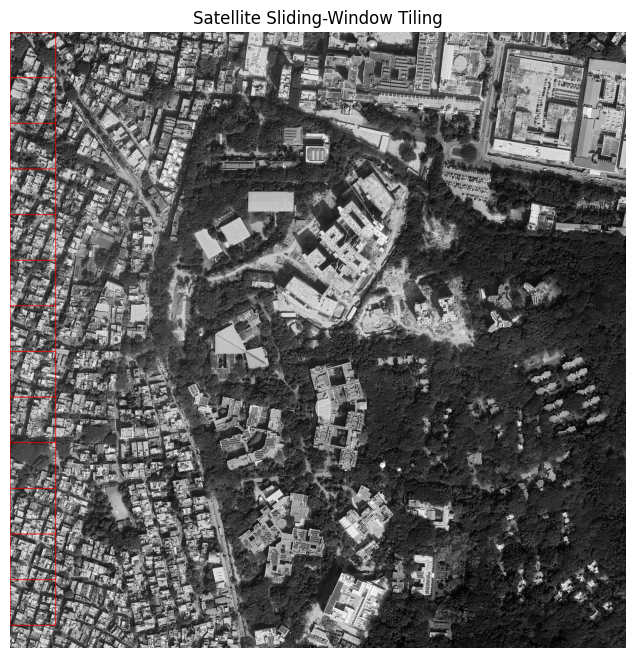

In [68]:
sat_tiles = tile_image(sat_gray)
vis = cv2.cvtColor(sat_gray, cv2.COLOR_GRAY2RGB)

for t in sat_tiles[::50]:
    x, y = t["offset"]
    cv2.rectangle(vis, (x,y), (x+512,y+512), (255,0,0), 8)

plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.title("Satellite Sliding-Window Tiling")
plt.axis("off")
plt.show()


In [83]:
sift = cv2.SIFT_create(nfeatures=4000)

def extract_sift(img):
    return sift.detectAndCompute(img, None)

In [84]:
sat_features = []

for t in sat_tiles:
    kp, des = extract_sift(t["tile"])
    if des is not None:
        sat_features.append({
            "kp": kp,
            "des": des,
            "offset": t["offset"],
            "tile": t["tile"]
        })


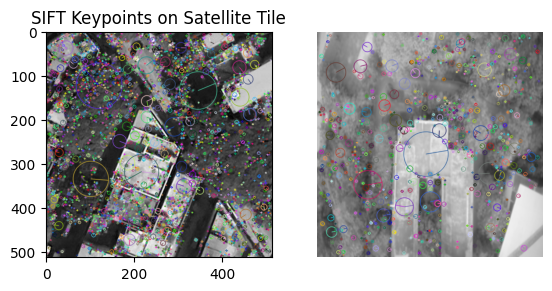

In [101]:
sample_tile = sat_features[0]["tile"]
kp, des = extract_sift(sample_tile)
kp_d, des_d = extract_sift(drone_imgs_proc[name])

kp_img = cv2.drawKeypoints(
    sample_tile, kp, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
kp_drone = cv2.drawKeypoints(
    drone_imgs_proc[name], kp_d, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.subplot(121).imshow(kp_img, cmap="gray")
plt.title("SIFT Keypoints on Satellite Tile")
plt.subplot(122).imshow(kp_drone, cmap="gray")
plt.axis("off")
plt.show()


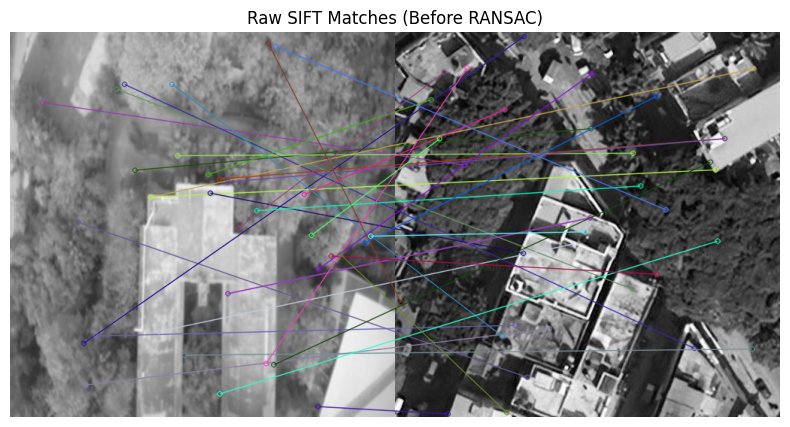

In [103]:

tile = sat_features[0]

# FLANN_INDEX_KDTREE = 0
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)

matches, good_matches = match_keypoints(des_d, tile["des"])
match_plot = cv2.drawMatches(drone_imgs_proc[name], kp_d, tile["tile"], tile["kp"], good_matches[:100], None, flags=2)

# match_img = cv2.drawMatches(
#     drone_imgs_proc[name], kp_d,
#     tile["tile"], tile["kp"],
#     matches[:40], None, flags=2
# )

plt.figure(figsize=(12,5))
plt.imshow(match_plot)
plt.title("Raw SIFT Matches (Before RANSAC)")
plt.savefig('output/SIFT_matches_plot.png')
plt.axis("off")
plt.show()


In [110]:
print(good_matches[0].queryIdx, good_matches[0].trainIdx)

51 654


In [125]:
def ransac_homography(kp_d, kp_s, matches):
    if len(matches) < 10:
        return None, 0

    src = np.float32([kp_d[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(
        src, dst,
        cv2.RANSAC,
        ransacReprojThreshold=6
    )

    inliers = int(mask.sum()) if mask is not None else 0
    
    if inliers<8:
        return None, inliers
    return H, inliers

In [126]:
H, inliers = ransac_homography(kp_d, tile["kp"], good_matches)
print("RANSAC Inliers:", inliers)

RANSAC Inliers: 6


In [114]:
print('matches, good matches, inliers:', len(matches), len(good_matches), inliers)

matches, good matches, inliers: 749 36 6


In [ ]:
results = {}

for name, drone_gray in drone_imgs_proc.items():
    # drone_gray = preprocess_drone(drone_img)
    kp_d, des_d = extract_sift(drone_gray)

    if des_d is None:
        continue

    best = {"inliers": 0}

    for tile in sat_features:
        matches = match_sift(des_d, tile["des"])
        if len(matches) < 25:
            continue

        H, inliers = ransac_homography(kp_d, tile["kp"], matches)

        if inliers > best["inliers"]:
            best = {
                "offset": tile["offset"],
                "H": H,
                "inliers": inliers
            }

    results[name] = best


In [ ]:
top_k = sorted(
    results.items(),
    key=lambda x: x[1]["inliers"],
    reverse=True
)[:5]

for name, res in top_k:
    x, y = res["offset"]

    vis = cv2.cvtColor(sat_gray, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(vis, (x,y), (x+512,y+512), (0,255,0), 4)

    plt.figure(figsize=(6,6))
    plt.imshow(vis)
    plt.title(f"{name} | Inliers: {res['inliers']}")
    plt.axis("off")
    plt.show()


In [ ]:
from tqdm import tqdm

results = {}

for name, drone_gray in tqdm(drone_imgs_proc.items(),
                             desc="Processing drone images",
                             total=len(drone_imgs_proc)):

    kp_d, des_d = extract_sift(drone_gray)

    if des_d is None:
        continue

    best = {"inliers": 0}

    for tile in sat_features:
        matches = match_sift(des_d, tile["des"])
        if len(matches) < 25:
            continue

        H, inliers = ransac_homography(kp_d, tile["kp"], matches)

        if inliers > best["inliers"]:
            best = {
                "offset": tile["offset"],
                "H": H,
                "inliers": inliers
            }

    results[name] = best


# Affine

In [ ]:
M, mask = cv2.estimateAffinePartial2D(
    src.reshape(-1,2),
    dst.reshape(-1,2),
    method=cv2.RANSAC,
    ransacReprojThreshold=6
)

In [ ]:
def robust_verify(kp_d, kp_s, matches):
    if len(matches) < 8:
        return None, 0

    src = np.float32([kp_d[m.queryIdx].pt for m in matches])
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

    M, mask = cv2.estimateAffinePartial2D(
        src, dst,
        cv2.RANSAC,
        ransacReprojThreshold=6
    )

    if mask is None or mask.sum() < 6:
        return None, 0

    # Optional homography refinement
    H, hmask = cv2.findHomography(
        src[mask.ravel() == 1].reshape(-1,1,2),
        dst[mask.ravel() == 1].reshape(-1,1,2),
        cv2.RANSAC,
        ransacReprojThreshold=4
    )

    inliers = int(hmask.sum()) if hmask is not None else int(mask.sum())
    return H, inliers


In [ ]:
inlier_matches = [m for i,m in enumerate(matches) if mask[i]]

inlier_img = cv2.drawMatches(
    drone_gray, kp_d,
    tile["tile"], tile["kp"],
    inlier_matches, None, flags=2
)

plt.figure(figsize=(12,5))
plt.imshow(inlier_img)
plt.title(f"Inliers Only ({len(inlier_matches)})")
plt.axis("off")
plt.show()


In [105]:
import numpy as np

def verify_matches(kp_d, kp_s, matches):
    src_pts = np.float32([kp_d[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp_s[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    inliers = mask.sum() if mask is not None else 0
    return H, inliers

best_match = None
max_inliers = 0

for tile, matches in candidate_tiles:
    H, inliers = verify_matches(kp_d, tile["keypoints"], matches)
    if inliers > max_inliers:
        max_inliers = inliers
        best_match = (tile, H)

NameError: name 'candidate_tiles' is not defined

In [104]:
len(matches), len(good_matches)

(749, 36)

In [69]:
orb = cv2.ORB_create(nfeatures=2000)

sat_features = []

for t in sat_tiles:
    kp, des = extract_orb(t["tile"])
    if des is not None:
        sat_features.append({
            "kp": kp,
            "des": des,
            "offset": t["offset"],
            "tile": t["tile"]
        })

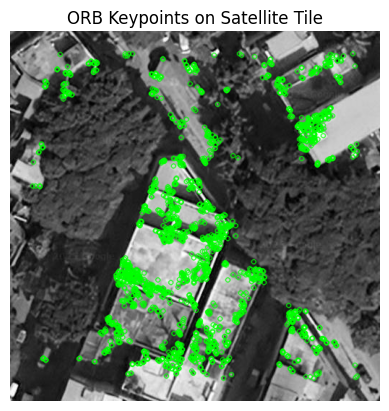

In [80]:
sample_tile = sat_features[0]["tile"]
kp,des = extract_orb(sample_tile)

kp_img = cv2.drawKeypoints(sample_tile, kp, None, color=(0,255,0))
plt.imshow(kp_img, cmap="gray")
plt.title("ORB Keypoints on Satellite Tile")
plt.axis("off")
plt.show()

# Matching Strategy (Drone → Satellite)

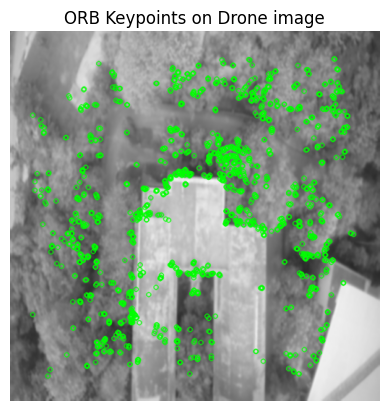

In [79]:
kp_d, des_d = extract_orb(drone_imgs_proc[name])
tile = sat_features[0]
kp_d = cv2.drawKeypoints(drone_imgs_proc[name], kp_d, None, color=(0,255,0))
plt.imshow(kp_d, cmap="gray")
plt.title("ORB Keypoints on Drone")
plt.axis("off")
plt.show()

# matches = match_features(des_d, tile["des"])

# match_img = cv2.drawMatches(
#     drone_imgs_proc[name], kp_d,
#     tile["tile"], tile["kp"],
#     matches[:40], None, flags=2
# )

# plt.figure(figsize=(12,5))
# plt.imshow(match_img)
# plt.title("Raw ORB Matches (Before RANSAC)")
# plt.axis("off")
# plt.show()

In [81]:
def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(desc_1,desc_2,k=2)
  good = []
  for i , (m, n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
      # good.append((m.trainIdx, m.queryIdx))
      good.append(m)
  # ===============================================
  return matches,good

In [82]:
[matches,good_matches] = match_keypoints(des, des_d)
match_plot = cv2.drawMatches(sample_tile, kp, drone_imgs_proc[name], kp_d, good_matches[:100], None, flags=2)
print("feature matcheing between image 1 and 2...")
print('%d feature matches found between image 1 and 2'%len(good_matches))
cv2_imshow(match_plot)

error: OpenCV(4.12.0) /io/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 

(np.float64(-0.5), np.float64(1023.5), np.float64(511.5), np.float64(-0.5))

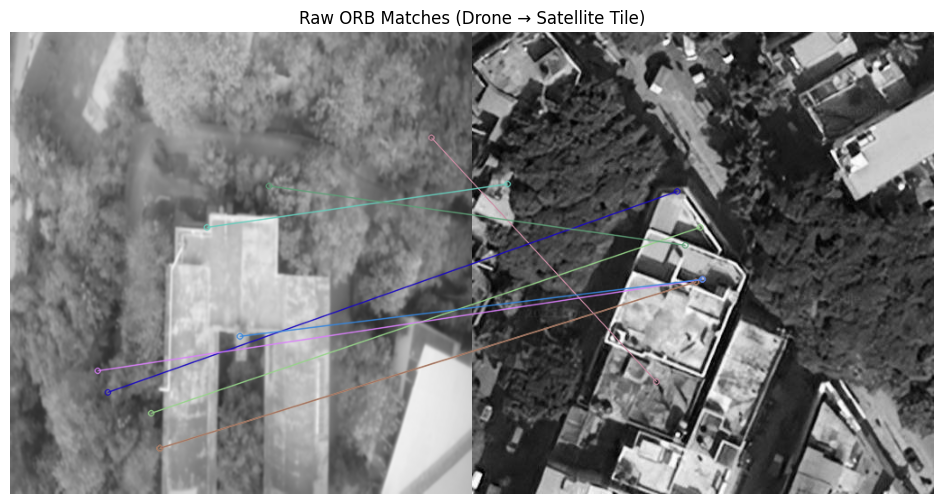

In [77]:
tile = sat_features[0]  # example tile for visualization

matches = match_features(des_d, tile["des"])

match_img = cv2.drawMatches(
    drone_img, kp_d,
    tile["tile"], tile["kp"],
    matches[:50], None, flags=2
)

plt.figure(figsize=(12,6))
plt.imshow(match_img, cmap="gray")
plt.title("Raw ORB Matches (Drone → Satellite Tile)")
os.makedirs('output', exist_ok = True)
plt.savefig("output/orb_matches.png", dpi=150)
plt.axis("off")
# plt.show()

In [75]:
H, inliers = ransac_verify(kp_d, tile["kp"], matches)

print("RANSAC Inliers:", inliers)

RANSAC Inliers: 0


In [43]:
# # Step 1: Extract Drone Features
# kp_d, des_d = extract_orb(drone_img)
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# #Step 2: Match Against Satellite Tiles (Coarse Search)
# def match_tile(des_d, tile_des):
#     matches = bf.knnMatch(des_d, tile_des, k=2)
#     good = []
#     for m, n in matches:
#         if m.distance < 0.75 * n.distance:  # Lowe's ratio
#             good.append(m)
#     return good
# #Step 3: Find Best Candidate Tiles
# candidate_tiles = []

# for tile in sat_features:
#     good_matches = match_tile(des_d, tile["descriptors"])
#     if len(good_matches) > 30:  # threshold
#         candidate_tiles.append((tile, good_matches))

In [45]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

def match_features(des_d, des_s, ratio=0.75):
    matches = bf.knnMatch(des_d, des_s, k=2)
    return [m for m,n in matches if m.distance < ratio * n.distance]
    
def ransac_verify(kp_d, kp_s, matches):
    if len(matches) < 10:
        return None, 0

    src = np.float32([kp_d[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    inliers = int(mask.sum()) if mask is not None else 0
    return H, inliers

good = match_features(des, tile["des"])
match_img = cv2.drawMatches(
    drone_img, kp, tile["tile"], tile["kp"], good[:50], None
)

plt.imshow(match_img)
plt.title("Raw Feature Matches")
plt.axis("off")
plt.show()



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [30]:

kp_img = cv2.drawKeypoints(
    tile, kp_d, None, color=(0,255,0), flags=0
)

plt.figure(figsize=(6,6))
plt.imshow(kp_img, cmap="gray")
plt.title("ORB Keypoints on Satellite Tile")
plt.axis("off")
plt.show()


NameError: name 'kp_d' is not defined

# Geometric verification

In [ ]:
import numpy as np

def verify_matches(kp_d, kp_s, matches):
    src_pts = np.float32([kp_d[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp_s[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    inliers = mask.sum() if mask is not None else 0
    return H, inliers

best_match = None
max_inliers = 0

for tile, matches in candidate_tiles:
    H, inliers = verify_matches(kp_d, tile["keypoints"], matches)
    if inliers > max_inliers:
        max_inliers = inliers
        best_match = (tile, H)

In [ ]:
results = {}

for name, drone_img in drone_imgs_proc.items():
    kp_d, des_d = extract_orb(drone_img)
    if des_d is None:
        continue

    best_tile, H = None, None
    max_inliers = 0

    for tile in sat_features:
        matches = match_tile(des_d, tile["descriptors"])
        if len(matches) < 30:
            continue

        H_tmp, inliers = verify_matches(kp_d, tile["keypoints"], matches)
        if inliers > max_inliers:
            max_inliers = inliers
            best_tile = tile
            H = H_tmp

    results[name] = {
        "tile_offset": best_tile["offset"],
        "homography": H,
        "inliers": max_inliers
    }
